

<p align="center">
<img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


## Predicting Carreau Equation Coefficients for Polymer AN-125

#### Mohammad Abdullah
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering





_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)
_________________________________________________________________________________________________________

### Executive Summary

Carreau equation is used to model non-Newtonian behavior change of polymer viscosity with sheer rate.Capturing non-Newtonian behavior requires extensive lab work as it varies with: polymer concentration, brine salinity,and temperature.Hence, I attempted to train machine learning techniques:linear and polynomial regression—based to fit Carreau constants using lab data of polymer AN-125—to minimize lab  work required to predict polymer viscosity.The features scattered plots indicated non-linearity and data scarcity in the problem.As I switched from linear model to polynomial model,I did not not observe significant improvement in response features prediction.Also,when changing the random samples select, the models predictions changed.Therefore, I expect  data scarcity to be the dominant factor hurdling models prediction.Moreover,I recommend investigating if the assumption of independent response features prediction affect model  prediction. 

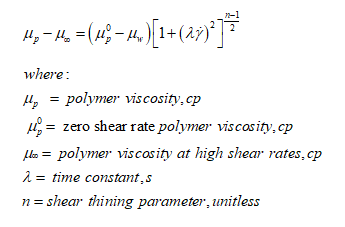

In [1]:
from IPython.display import Image #Import Carreau equation as image
Image(r"C:\Users\Mohammad Abdullah\Desktop\UT Courses\Fall 2020\Machine Learning\Project/equation.png")

### Import Packages

In [2]:
import numpy as np                                          # ndarrys for gridded data
from sklearn.linear_model import LinearRegression           # linear regression with scikit learn
import pandas as pd                                         # DataFrames for tabular data
import pandas.plotting as pd_plot                         # matrix scatter plots
import os                                                   # set working directory, run executables
import matplotlib.pyplot as plt                             # for plotting
from scipy import stats                                     # summary statistics
import math                                                 # trig etc.
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.linear_model import Ridge                      # ridge regression implemented in scikit learn
from sklearn.preprocessing import PolynomialFeatures        # polynomial basis expansion
from sklearn.metrics import mean_squared_error, r2_score    # specific measures to check our models
import seaborn as sns                                       # Seaborn visualization library                  
from sklearn.preprocessing import QuantileTransformer       # for Gaussian normalization of data
import geostatspy.geostats as geostats                      # for Gaussian normalization of data(private package by Dr. Micheal Pyrcz)

### Load Data

The following workflow applies the .cvs file 'my_data1.csv',an actual data-set of Carreau constants calculated by fitting lab data of polymer AN-125.
Data are extracted from:
*Lee, A. 2010. A Polymer Hydrolysis Model and Its Application in Chemical EOR Process Simulation. Master of Science in Engineering, The University of Texas at Austin.*

We will work with the following features:
#### Predictive features:
* **concentration** - polymer concentration in solution (ppm)
* **Csep** - effective salinity (meq/mL)


#### Response Features (Carruea model coefficients):
* **mu_zero** - zero shear rate viscosity (cp)
* **lampda** - Carreau model time constant (s^-1)
* **n** - shear thinning index 

#### Other features:
* **mu_w** - water viscosity (cp), which is calculated using Vogel's equation and will not be considered in our training dataset.
* **Salinity** - brine water salinity-NaCl equivalent (ppm)
* **Hardness** - brine water divalent (ppm)
* **Temperature** - experiment temperature (C)

* Now we will set data directory and load data

In [21]:
os.chdir(r"C:\Users\Mohammad Abdullah\Desktop\UT Courses\Fall 2020\Machine Learning\Project")    #set directory                                   # set the working directory
data = pd.read_csv("PGE383_Project_Mohammad_Abdullah_data.csv")                   # load the comma delimited data file

###  Basic Data Checking and Visualization

* We will visualize the tabulated data, we have 27 flow curves which were fit using non-linear regression.Note: data processing was conducted out of this workflow.

In [5]:
data.head()   # to visualize data in tabulated format

,concentration,Salinity,Hardness,Temperature,mu_w,mu_zero,lampda,n
0,500,1000,0,25,0.8903,10.952395,0.310986,0.716148
1,1000,1000,0,25,0.8903,52.125225,1.302138,0.653347
2,1000,1000,0,25,0.8903,34.174320,0.346513,0.652563
3,1000,5000,0,25,0.8903,11.000000,0.130000,0.692000
4,1000,10000,0,25,0.8903,7.325464,0.124994,0.798587


#### Feature engineering selection
In this subsection, we try to reduce the dimentionality of the problem based on engineering methods as follow:


**1.**  Convert monovalents and divalents into effective salinity (Csep).Csep is a conversion of the anionity strength of anions and divalents into equivalent volume dissolved in water.
*Ref.:Sheng, J.J. 2011. Modern Chemical Enhanced Oil Recovery: Theory and Practice. Modern Chemical Enhanced Oil Recovery: Theory and Practice, 1-617.*

In [6]:
data['Csep']=data['Salinity']/(58.5*1000) + 9*data['Hardness']/(20*1000) # add a new feature with effective salinity

**2.** Exclude water viscosity  and temperature from the data, as they can be separately calculated using Vogel's 
correlation and then plug it in Carreau equation.
*Vogel's correlation correlates water viscosity to temperature.For more see:
http://ddbonline.ddbst.de/VogelCalculation/VogelCalculationCGI.exe?component=Water*

* Now let's visualize the new data

In [7]:
data_new=data.iloc[:, [0,5,6,7,8]] 
data_new.head()  #visualize the new data set

,concentration,mu_zero,lampda,n,Csep
0,500,10.952395,0.310986,0.716148,0.017094
1,1000,52.125225,1.302138,0.653347,0.017094
2,1000,34.174320,0.346513,0.652563,0.017094
3,1000,11.000000,0.130000,0.692000,0.085470
4,1000,7.325464,0.124994,0.798587,0.170940


* Let's have a full statistics of our data range

In [8]:
data_new.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
concentration,27.0,2055.555556,974.021534,500.000000,1000.000000,2000.000000,3000.000000,3000.000000
mu_zero,27.0,33.128520,24.365842,2.563734,11.087057,30.963632,46.865992,78.474648
lampda,27.0,0.471596,0.329655,0.067051,0.236446,0.380491,0.615699,1.302138
n,27.0,0.733314,0.061955,0.652563,0.688515,0.716148,0.760701,0.867034
Csep,27.0,0.338256,0.292012,0.017094,0.170940,0.170940,0.544017,1.133761


The numbers looks reasonable where  0.5<n<1,and no -ve values.
*Ref: Sorbie, K.S. 1990. Polymer-Improved Oil Recovery. Springer Science & Business Media, USA.*

#### Constants definitions
* Set max and min values for predictor and responce features, which will help in the workflow

In [9]:
con_min = 500; con_max = 3000                    # predictor feature 1(concentration) range
Csep_min = 0; Csep_max = 1.15                     # predictor feature 1(Csep), range
mu_min = 2.5; mu_max = 80                        # response feature 1 (mu_zero) range           
lampda_min = 0; lampda_max =1.4                   # response feature 2(lampda) range
n_min = 0.6; n_max =0.9                           # response feature 3 (n) range
cmap = plt.cm.inferno                             # color map, variable tone and intensity for color blind individuals, and inferno is rad

* Let's visualize bilinear correlations between data.

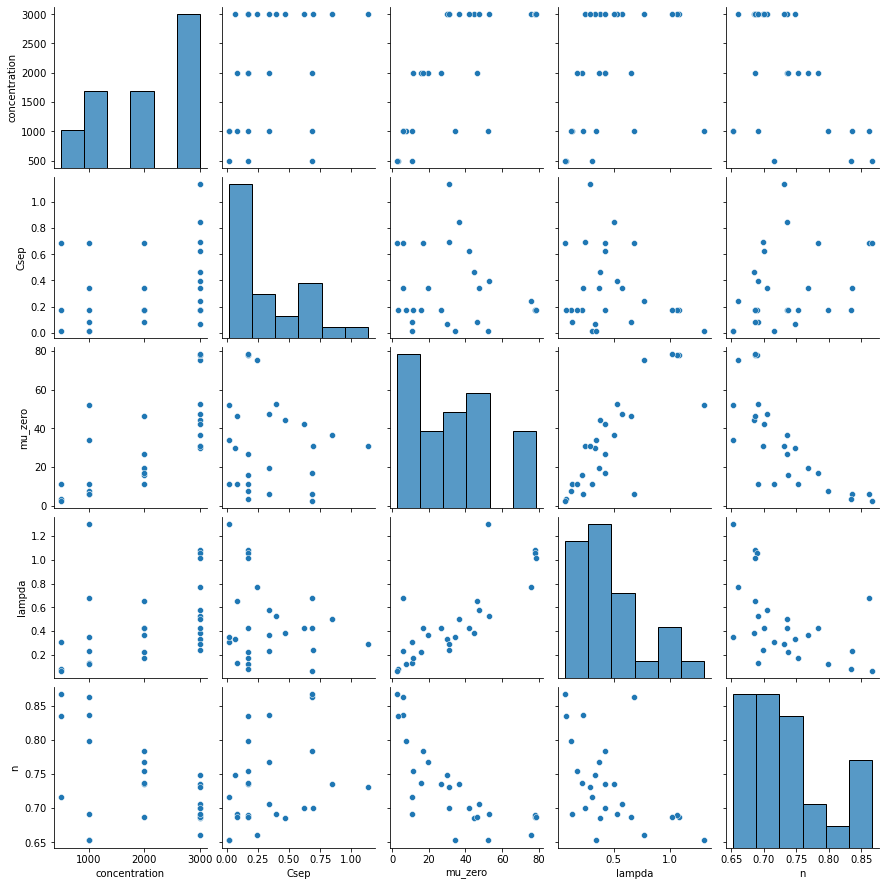

In [10]:
sns.pairplot(data_new,vars=['concentration','Csep','mu_zero','lampda','n'],markers='o') # matrix scatter plot

From the histograms, a fair continuity in data can be observed(except for two concentration values).From the scattered plots, the correlation between predictive  and response features is nonlinear (see Csep) and discrete (see concentration).

* Therefore, let us construct scattered plots between the two predictive features (concentration and Csep) and each response—to account for  multi-dimensionality.

<ipython-input-11-42eb4a68ead1>:3: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["mu_zero"], marker=None, cmap=cmap, norm=None,vmin=mu_min, vmax=mu_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
<ipython-input-11-42eb4a68ead1>:10: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["n"], marker=None, cmap=cmap, norm=None,vmin=n_min, vmax=n_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
<ipython-input-11-42eb4a68ead1>:17: MatplotlibDepre

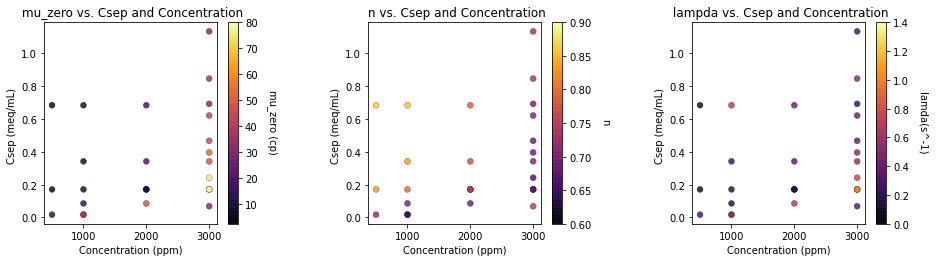

In [11]:
plt.subplot(1,3,1)                                          # scatter plot of the training data, 1 row x 3 columns
#im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["mu_zero"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["mu_zero"], marker=None, cmap=cmap, norm=None,vmin=mu_min, vmax=mu_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title(' mu_zero vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("mu_zero (cp) ", rotation=270, labelpad=20)

plt.subplot(1,3,2)                                          # scatter plot of the training data, 1 row x 2 columns
#im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["mu_zero"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["n"], marker=None, cmap=cmap, norm=None,vmin=n_min, vmax=n_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title(' n vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("n ", rotation=270, labelpad=20)

plt.subplot(1,3,3)                                          # scatter plot of the training data, 1 row x 2 columns
#im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["mu_zero"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
im = plt.scatter(data_new["concentration"],data_new["Csep"],s=None, c=data_new["lampda"], marker=None, cmap=cmap, norm=None,vmin=lampda_min, vmax=lampda_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title(' lampda vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("lamda(s^-1) ", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.8, right=2, top=1.5, wspace=0.5, hspace=0.3)
plt.show()

Form the plots, mu_zero is proportional directly to concentration and inversely to Csep.Shear thinning index (n) seems more sensitive to Csep compared to concentration change.Meanwhile, lamda seems inversely proportional to Csep and hard to visualize its correlation to concentration.

### Workflow: Carreau Coefficients Prediction Using Linear and Polynomial Regression
We will predict Carreau coefficients by training and testing linear and polynomial regression models as follow:

**1.** Split data into training and testing sets, and check testing data representation(fairness).

**2.** Start training and testing linear regression model and check its prediction performance.

**3.** Search for the optimum degree of polynomial model—with least testing MSE.

**4.** Train and test the select polynomial model,and check its prediction performance.

**5** Results: Compare linear regression model an non-linear, and draw conclusions.


**Worflow credit** goes to Dr.Michel Pyrcz (https://github.com/GeostatsGuy) for using his worflows in this project.

### 1. Train and Test Split

Now we do a train and test split with scikit-learn's .train_test_split() function.We will select 20% of data for testing and 80% for training using random selection.

where:

**x**= Predictive features:
* **concentration** - polymer concentration in volume (ppm)
* **Csep** - effective salinity (meq/mL)


**y**= Response Features (Carreau model coefficients):
* **mu_zero** - zero shear rate viscosity (cp)
* **lampda** - Carreau model time constant (s^-1)
* **n** - shear thinning index

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data_new.iloc[:,[0,4]], data_new.iloc[:,[1,2,3]], test_size=0.2, random_state=None)

* Plotting to check the training response and predictive features distribution 

<ipython-input-13-9d35ea39a06c>:3: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(x_train["concentration"],x_train["Csep"],s=None, c=y_train["mu_zero"], marker=None, cmap=cmap, norm=None,vmin=mu_min, vmax=mu_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
<ipython-input-13-9d35ea39a06c>:9: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(x_train["concentration"],x_train["Csep"],s=None, c=y_train["n"], marker=None, cmap=cmap, norm=None,vmin=n_min, vmax=n_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
<ipython-input-13-9d35ea39a06c>:15: MatplotlibDeprecationW

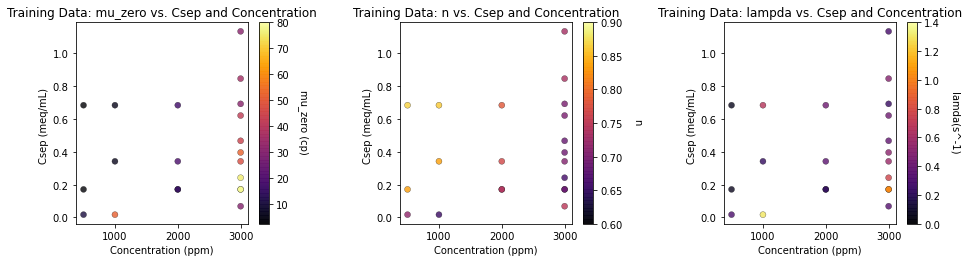

In [13]:
##training plots
plt.subplot(1,3,1)                                          # scatter plot of the training data, 1 row x 3 columns
im = plt.scatter(x_train["concentration"],x_train["Csep"],s=None, c=y_train["mu_zero"], marker=None, cmap=cmap, norm=None,vmin=mu_min, vmax=mu_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Data: mu_zero vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("mu_zero (cp) ", rotation=270, labelpad=20)

plt.subplot(1,3,2)                                          # scatter plot of the training data, 1 row x 2 columns
im = plt.scatter(x_train["concentration"],x_train["Csep"],s=None, c=y_train["n"], marker=None, cmap=cmap, norm=None,vmin=n_min, vmax=n_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Data: n vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("n ", rotation=270, labelpad=20)

plt.subplot(1,3,3)                                          # scatter plot of the training data, 1 row x 2 columns
im = plt.scatter(x_train["concentration"],x_train["Csep"],s=None, c=y_train["lampda"], marker=None, cmap=cmap, norm=None,vmin=lampda_min, vmax=lampda_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Training Data: lampda vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("lamda(s^-1) ", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.8, right=2, top=1.5, wspace=0.5, hspace=0.3)
plt.show()

We can observe that the randomly selected training data covers the original data trend.

* Now let us plot testing data to check the fairness of test fairness.

<ipython-input-14-5624bbf5284b>:3: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(x_test["concentration"],x_test["Csep"],s=None, c=y_test["mu_zero"], marker=None, cmap=cmap, norm=None,vmin=mu_min, vmax=mu_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
<ipython-input-14-5624bbf5284b>:9: MatplotlibDeprecationWarning: 
The 'verts' parameter of scatter() was deprecated in Matplotlib 3.2 and will be removed two minor releases later. If any parameter follows 'verts', they should be passed as keyword, not positionally.
  im = plt.scatter(x_test["concentration"],x_test["Csep"],s=None, c=y_test["n"], marker=None, cmap=cmap, norm=None,vmin=n_min, vmax=n_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
<ipython-input-14-5624bbf5284b>:15: MatplotlibDeprecationWarning

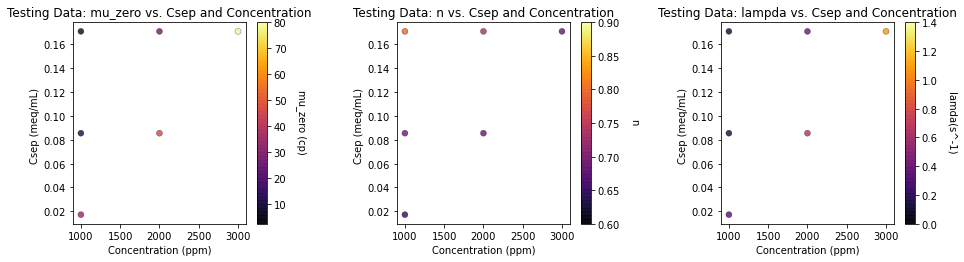

In [14]:
## testing plot
plt.subplot(1,3,1)                                          # scatter plot of the training data, 1 row x 3 columns
im = plt.scatter(x_test["concentration"],x_test["Csep"],s=None, c=y_test["mu_zero"], marker=None, cmap=cmap, norm=None,vmin=mu_min, vmax=mu_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Data: mu_zero vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("mu_zero (cp) ", rotation=270, labelpad=20)

plt.subplot(1,3,2)                                          # scatter plot of the training data, 1 row x 3 columns
im = plt.scatter(x_test["concentration"],x_test["Csep"],s=None, c=y_test["n"], marker=None, cmap=cmap, norm=None,vmin=n_min, vmax=n_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Data: n vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("n ", rotation=270, labelpad=20)

plt.subplot(1,3,3)                                          # scatter plot of the training data, 1 row x 3 columns
im = plt.scatter(x_test["concentration"],x_test["Csep"],s=None, c=y_test["lampda"], marker=None, cmap=cmap, norm=None,vmin=lampda_min, vmax=lampda_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Testing Data: lampda vs. Csep and Concentration'); plt.xlabel('Concentration (ppm)'); plt.ylabel('Csep (meq/mL) ')
cbar = plt.colorbar(im, orientation = 'vertical'); #plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("lamda(s^-1) ", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.8, right=2, top=1.5, wspace=0.5, hspace=0.3)
plt.show()

Although the scarcity of testing data, we observe fair sampling.

### 2. Linear Regression Model
Let's start by trying the simplest prediction method that assume linear relation between predictive and response features.
* We use linear regression as a building block in increasing prediction model complexity, and to better evaluate the problem non-linearity and complexity.
* I will construct three models to predict the three responses separately.Here, we assume that the response features can be predicted independently.

* Now, let's fit training data and check model training prediction performance:

mu_zero Variance explained training of Linear Rergression: 227.50
mu_zero Training: Average error of Linear Regression= -0.0000000000
mu_zero Training: Standard Deviation error of Linear Regression= 15.08
Lampda Variance explained training of Linear Regression: 0.08
Lampda Training: Average error of Linear Regression= 0.0000000000
Lampda Training: Standard Deviation error of Linear Regression= 0.29
n Variance explained training of Linear Regression: 0.00
n Training: Average error of Linear Regression= -0.0000000000
n Training: Standard Deviation error of Linear Regression= 0.04


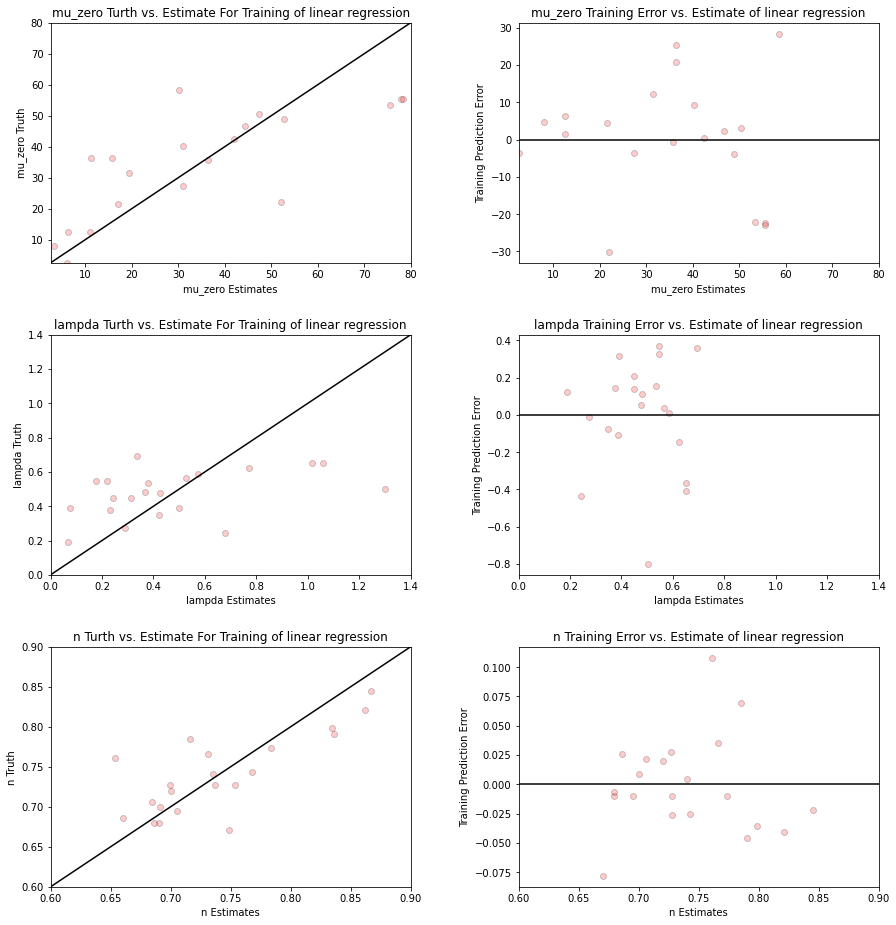

In [15]:
#Model fitting
lam1=0#linear regression using ridge regression function
######################################
# Step 1. Instantiate the Model 
######################################
linear_reg = Ridge(alpha=lam1) #linear regression
linear_reg1 = Ridge(alpha=lam1) #linear regression
linear_reg2 = Ridge(alpha=lam1) #linear regression

#linear regression
#mu_zero fit
linear_reg.fit(x_train.values,y_train['mu_zero'].values) # train (fit) the model with the training data
#lampda fit
linear_reg1.fit(x_train.values,y_train['lampda'].values) # train (fit) the model with the training data
#n fit
linear_reg2.fit(x_train.values,y_train['n'].values) # train (fit) the model with the training data
######################################
# Step 2. Make predictions using the training dataset and calculate MSE,Std Deviation,and Variance
######################################
#mu_zero
y_train_pred = linear_reg.predict(x_train.values) 
#Linear Regression
MSE_train = mean_squared_error(y_train['mu_zero'], y_train_pred)           # calculate the training MSE      
print('mu_zero Variance explained training of Linear Rergression: %.2f' % MSE_train)
y_train_resid = y_train_pred - y_train['mu_zero'].values     # calculate the residuals over the training data
print('mu_zero Training: Average error of Linear Regression= %.10f' % np.average(y_train_resid)) # calculate the average testing error 
print('mu_zero Training: Standard Deviation error of Linear Regression= %.2f' % np.std(y_train_resid)) # calculate the standard deviation testing error
y_train_resid_linear=y_train_resid #dummy variable to save error for results section
#lampda
y_train_pred1 = linear_reg1.predict(x_train.values) 
#Linear Regression
MSE_train1 = mean_squared_error(y_train['lampda'], y_train_pred1)           # calculate the training MSE      
print('Lampda Variance explained training of Linear Regression: %.2f' % MSE_train1)
y_train_resid1 = y_train_pred1 - y_train['lampda'].values     # calculate the residuals over the training data
print('Lampda Training: Average error of Linear Regression= %.10f' % np.average(y_train_resid1)) # calculate the average testing error 
print('Lampda Training: Standard Deviation error of Linear Regression= %.2f' % np.std(y_train_resid1)) # calculate the standard deviation testing error
y_train_resid1_linear=y_train_resid1 #dummy variable to save error for results section

#n
y_train_pred2 = linear_reg2.predict(x_train.values) 
#Linear Regression
MSE_train2 = mean_squared_error(y_train['n'], y_train_pred2)           # calculate the training MSE      
print('n Variance explained training of Linear Regression: %.2f' % MSE_train2)
y_train_resid2 = y_train_pred2 - y_train['n'].values     # calculate the residuals over the training data
print('n Training: Average error of Linear Regression= %.10f' % np.average(y_train_resid2)) # calculate the average testing error 
print('n Training: Standard Deviation error of Linear Regression= %.2f' % np.std(y_train_resid2)) # calculate the standard deviation testing error
y_train_resid2_linear=y_train_resid2 #dummy variable to save error for results section

######################################
# Step 3. Plot tratining prediction error
######################################
#my zero
plt.subplot(3,3,2)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train['mu_zero'].values,y_train_pred,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Turth vs. Estimate For Training of linear regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('mu_zero Truth')
plt.plot([mu_min,mu_max],[mu_min,mu_max],c='black')
plt.xlim(mu_min,mu_max); plt.ylim(mu_min,mu_max)

plt.subplot(3,3,3)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred,y_train_resid,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Training Error vs. Estimate of linear regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('Training Prediction Error')
plt.plot([mu_min,mu_max],[0,0],c='black')
plt.xlim(mu_min,mu_max); #plt.ylim(-100,100)

#lampda
plt.subplot(3,3,5)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train['lampda'].values,y_train_pred1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Turth vs. Estimate For Training of linear regression'); plt.xlabel('lampda Estimates'); plt.ylabel('lampda Truth')
plt.plot([lampda_min,lampda_max],[lampda_min,lampda_max],c='black')
plt.xlim(lampda_min,lampda_max); plt.ylim(lampda_min,lampda_max)

plt.subplot(3,3,6)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred1,y_train_resid1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Training Error vs. Estimate of linear regression'); plt.xlabel('lampda Estimates'); plt.ylabel('Training Prediction Error')
plt.plot([lampda_min,lampda_max],[0,0],c='black')
plt.xlim(lampda_min,lampda_max); #plt.ylim(-100,100)

#n
plt.subplot(3,3,8)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train['n'].values,y_train_pred2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Turth vs. Estimate For Training of linear regression'); plt.xlabel('n Estimates'); plt.ylabel('n Truth')
plt.plot([n_min,n_max],[n_min,n_max],c='black')
plt.xlim(n_min,n_max); plt.ylim(n_min,n_max)

plt.subplot(3,3,9)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred2,y_train_resid2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Training Error vs. Estimate of linear regression'); plt.xlabel('n Estimates'); plt.ylabel('Training Prediction Error')
plt.plot([n_min,n_max],[0,0],c='black')
plt.xlim(n_min,n_max); #plt.ylim(-100,100)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=3, wspace=0.3, hspace=0.3)
plt.show()

We can observe a poor prediction of response features—even for the training data.This illustrates that large non-linear relation, which contradict the linear regression assumption, specially lampda and n.Therefore, I expect poor prediction for testing data.

* Now, Let's check the testing data prediction:

mu_zero Variance explained testing of Linear Rereeion: 165.10
mu_zero Testing: Average error of Linear Regression= -2.1644378985
mu_zero Testing: Standard Deviation error of Linear Regression= 12.67
Lampda Variance explained testing of Linear Rereeion: 0.08
Lampda Testing: Average error of Linear Regression= 0.0729653741
Lampda Testing: Standard Deviation error of Linear Regression= 0.26
n Variance explained testing of Linear Rereeion: 0.00
n Testing: Average error of Linear Regression= 0.0297637663
n Testing: Standard Deviation error of Linear Regression= 0.05


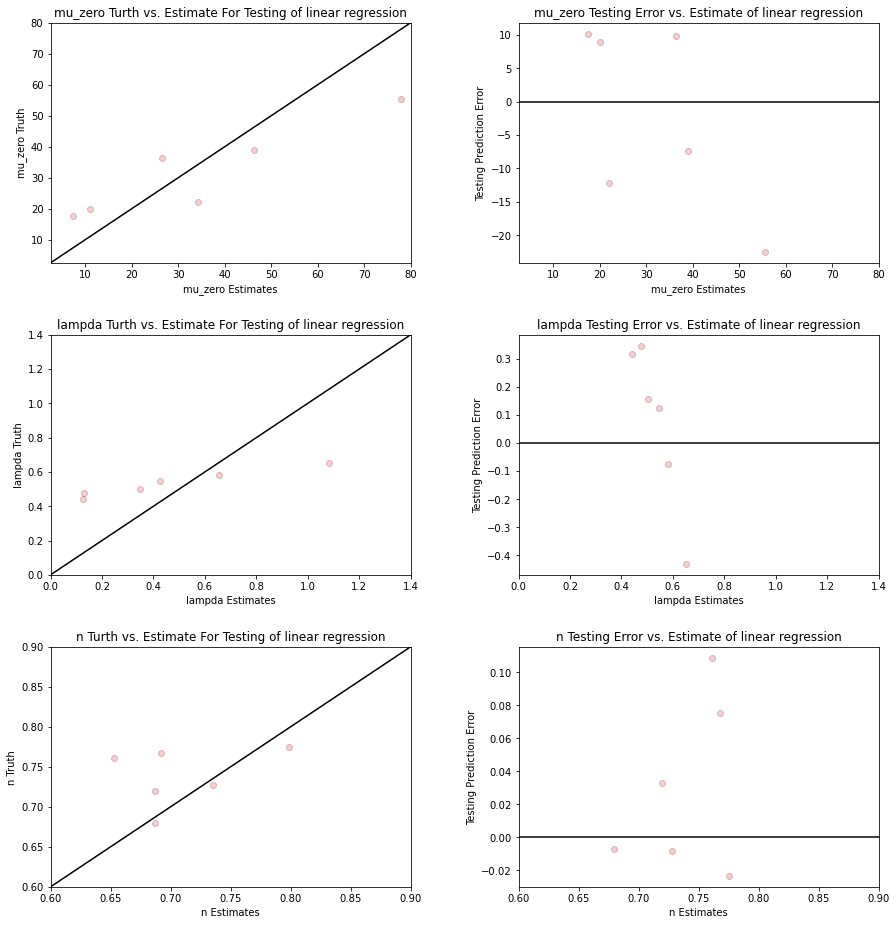

In [16]:
######################################
# Step 1. Make predictions using the testing dataset and calculate MSE,Std Deviation,and Variance
######################################
#mu_zero
y_test_pred = linear_reg.predict(x_test.values) 
#Linear Regression
MSE_test = mean_squared_error(y_test['mu_zero'], y_test_pred)           # calculate the training MSE      
print('mu_zero Variance explained testing of Linear Rereeion: %.2f' % MSE_test)
y_test_resid = y_test_pred - y_test['mu_zero'].values     # calculate the residuals over the training data
print('mu_zero Testing: Average error of Linear Regression= %.10f' % np.average(y_test_resid)) # calculate the average testing error 
print('mu_zero Testing: Standard Deviation error of Linear Regression= %.2f' % np.std(y_test_resid)) # calculate the standard deviation testing error
y_test_resid_linear=y_test_resid #dummy variable to save error for results section

#lampda
y_test_pred1 = linear_reg1.predict(x_test.values) 
#Linear Regression
MSE_test1 = mean_squared_error(y_test['lampda'], y_test_pred1)           # calculate the training MSE      
print('Lampda Variance explained testing of Linear Rereeion: %.2f' % MSE_test1)
y_test_resid1 = y_test_pred1 - y_test['lampda'].values     # calculate the residuals over the training data
print('Lampda Testing: Average error of Linear Regression= %.10f' % np.average(y_test_resid1)) # calculate the average testing error 
print('Lampda Testing: Standard Deviation error of Linear Regression= %.2f' % np.std(y_test_resid1)) # calculate the standard deviation testing error
y_test_resid1_linear=y_test_resid1 #dummy variable to save error for results section

#n
y_test_pred2 = linear_reg2.predict(x_test.values) 
#Linear Regression
MSE_test2 = mean_squared_error(y_test['n'], y_test_pred2)           # calculate the training MSE      
print('n Variance explained testing of Linear Rereeion: %.2f' % MSE_test2)
y_test_resid2 = y_test_pred2 - y_test['n'].values     # calculate the residuals over the training data
print('n Testing: Average error of Linear Regression= %.10f' % np.average(y_test_resid2)) # calculate the average testing error 
print('n Testing: Standard Deviation error of Linear Regression= %.2f' % np.std(y_test_resid2)) # calculate the standard deviation testing error
y_test_resid2_linear=y_test_resid2 #dummy variable to save error for results section

######################################
# Step 2. Plot testing prediction error
######################################
#my zero
plt.subplot(3,3,2)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test['mu_zero'].values,y_test_pred,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Turth vs. Estimate For Testing of linear regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('mu_zero Truth')
plt.plot([mu_min,mu_max],[mu_min,mu_max],c='black')
plt.xlim(mu_min,mu_max); plt.ylim(mu_min,mu_max)
plt.subplot(3,3,3)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred,y_test_resid,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Testing Error vs. Estimate of linear regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('Testing Prediction Error')
plt.plot([mu_min,mu_max],[0,0],c='black')
plt.xlim(mu_min,mu_max); #plt.ylim(-100,100)
#lampda
plt.subplot(3,3,5)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test['lampda'].values,y_test_pred1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Turth vs. Estimate For Testing of linear regression'); plt.xlabel('lampda Estimates'); plt.ylabel('lampda Truth')
plt.plot([lampda_min,lampda_max],[lampda_min,lampda_max],c='black')
plt.xlim(lampda_min,lampda_max); plt.ylim(lampda_min,lampda_max)
plt.subplot(3,3,6)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred1,y_test_resid1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Testing Error vs. Estimate of linear regression'); plt.xlabel('lampda Estimates'); plt.ylabel('Testing Prediction Error')
plt.plot([lampda_min,lampda_max],[0,0],c='black')
plt.xlim(lampda_min,lampda_max); #plt.ylim(-100,100)
#n
plt.subplot(3,3,8)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test['n'].values,y_test_pred2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Turth vs. Estimate For Testing of linear regression'); plt.xlabel('n Estimates'); plt.ylabel('n Truth')
plt.plot([n_min,n_max],[n_min,n_max],c='black')
plt.xlim(n_min,n_max); plt.ylim(n_min,n_max)
plt.subplot(3,3,9)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred2,y_test_resid2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Testing Error vs. Estimate of linear regression'); plt.xlabel('n Estimates'); plt.ylabel('Testing Prediction Error')
plt.plot([n_min,n_max],[0,0],c='black')
plt.xlim(n_min,n_max);# plt.ylim(-100,100)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=3, wspace=0.3, hspace=0.3)
plt.show()

As expected, the testing data show poor prediction of response features.

### 3. Polynomial Regression
Now, let's try a more complex model compared to linear regression.

* Polynomial models should perform better prediction in non-linear relations, and they are a step higher in complexity compared to linear regression model.

* **Searching for optimum polynomial degree for each response feature:**

Minimum MSE for mu_zero is when order  = 2
Minimum MSE for lampda is when order  = 2
Minimum MSE for n is when order  = 4


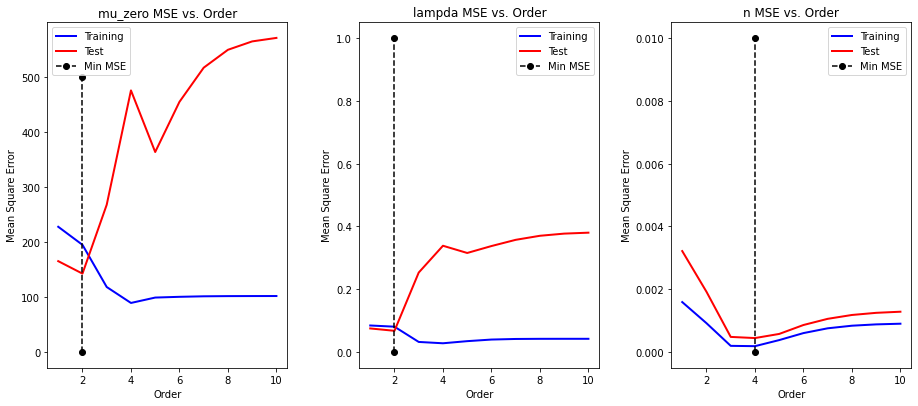

In [17]:
max_order=10 # maximum order +1 for iteration
min_order=1 #always 1
order = list(range(min_order, max_order+1))


#order = np.linspace(0,max_order,max_order-1)
MSE_train = np.zeros(len(order)); MSE_test = np.zeros(len(order));
MSE_train1 = np.zeros(len(order)); MSE_test1 = np.zeros(len(order));
MSE_train2 = np.zeros(len(order)); MSE_test2 = np.zeros(len(order));

for i in range(min_order,max_order+1):
    
    poly4 = PolynomialFeatures(degree = i) 
    mu_zero_poly4 = poly4.fit_transform(x_train.values) 
    lin_poly4 = LinearRegression() 
    lin_poly4.fit(mu_zero_poly4, y_train['mu_zero']) 
    y_train_pred=lin_poly4.predict(poly4.fit_transform(x_train.values))
    y_train_resid = y_train_pred - y_train['mu_zero'].values     # calculate the residuals over the training data
    y_test_pred=lin_poly4.predict(poly4.fit_transform(x_test.values))
    y_test_resid = y_test_pred - y_test['mu_zero'].values     # calculate the residuals over the testing data
    MSE_train[i-1]= mean_squared_error(y_train['mu_zero'].values, y_train_pred)           # calculate the training MSE  
    #MSE_train[i]=MSE_train
    MSE_test[i-1] = mean_squared_error(y_test['mu_zero'].values, y_test_pred)           # calculate the testing MSE
    
    
    #lampda
    lampda_poly4 = poly4.fit_transform(x_train.values) 
    lin_poly4 = LinearRegression() 
    lin_poly4.fit(lampda_poly4, y_train['lampda']) 
    y_train_pred1 = lin_poly4.predict(poly4.fit_transform(x_train.values))
    y_train_resid1 = y_train_pred1 - y_train['lampda'].values     # calculate the residuals over the testing data

    y_test_pred1=lin_poly4.predict(poly4.fit_transform(x_test.values))
    y_test_resid1 = y_test_pred1 - y_test['lampda'].values     # calculate the residuals over the testing data

    MSE_train1[i-1] = mean_squared_error(y_train['lampda'], y_train_pred1)           # calculate the training MSE   
    MSE_test1[i-1] = mean_squared_error(y_test['lampda'], y_test_pred1)           # calculate the testing MSE  
    
    #n
    lampda_poly4 = poly4.fit_transform(x_train.values) 
    lin_poly4 = LinearRegression() 
    lin_poly4.fit(lampda_poly4, y_train['n']) 
    y_train_pred2 = lin_poly4.predict(poly4.fit_transform(x_train.values))
    y_train_resid2 = y_train_pred2 - y_train['n'].values     # calculate the residuals over the testing data

    y_test_pred2=lin_poly4.predict(poly4.fit_transform(x_test.values))
    y_test_resid2 = y_test_pred2 - y_test['n'].values     # calculate the residuals over the testing data

    MSE_train2[i-1] = mean_squared_error(y_train['n'], y_train_pred2)           # calculate the training MSE      
    MSE_test2[i-1] = mean_squared_error(y_test['n'], y_test_pred2)           # calculate the testing MSE  

###########
#identifying the optimum order ID
imin = np.argmin(MSE_test)    
imin1 = np.argmin(MSE_test1)  
imin2 = np.argmin(MSE_test2)    
tuned_order = int(order[imin])                         # get the hyperparameter value with the minimum testing error
tuned_order1 = int(order[imin1])                         # get the hyperparameter value with the minimum testing error
tuned_order2 = int(order[imin2])                         # get the hyperparameter value with the minimum testing error

print('Minimum MSE for mu_zero is when order  = %.0f' % tuned_order)  
print('Minimum MSE for lampda is when order  = %.0f' % tuned_order1)  
print('Minimum MSE for n is when order  = %.0f' % tuned_order2)  

######### plotting the searching minimum eror 
plt.subplot(1,3,1)
plt.plot(order, MSE_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(order, MSE_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([imin+1,imin+1],[0,500],'go--',color='black',label='Min MSE') # vertical line at hyperparameter value that minimizes testing error 
plt.title('mu_zero MSE vs. Order'); plt.xlabel('Order'); plt.ylabel('Mean Square Error')
#plt.xlim(2,ncases); plt.ylim(1,100.0); 
#plt.xscale("linear"); plt.yscale("log")
#plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

plt.subplot(1,3,2)
plt.plot(order, MSE_train1,  color='blue', linewidth = 2, label = 'Training')
plt.plot(order, MSE_test1,  color='red', linewidth = 2, label = 'Test')
plt.plot([imin1+1,imin1+1],[0,1],'go--',color='black',label='Min MSE') # vertical line at hyperparameter value that minimizes testing error 
plt.legend()
plt.title('lampda MSE vs. Order'); plt.xlabel('Order'); plt.ylabel('Mean Square Error')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)


plt.subplot(1,3,3)
plt.plot(order, MSE_train2,  color='blue', linewidth = 2, label = 'Training')
plt.plot(order, MSE_test2,  color='red', linewidth = 2, label = 'Test')
plt.plot([imin2+1,imin2+1],[0,0.01],'go--',color='black',label='Min MSE') # vertical line at hyperparameter value that minimizes testing error 
plt.legend()
plt.title('n MSE vs. Order'); plt.xlabel('Order'); plt.ylabel('Mean Square Error')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

It seems that the response features have different  optimum orders for prediction.This can be due to different correlation with the predictive features.Also, an important observation is that every time i select a random testing samples , i came up with different optimum orders.This signifies the impact of data scarcity and sparsity.Still, response feature (n) always showed better prediction with order>1, which explains the need for non-linearity for this parameter.

### 4. Train & Test The Select Polynomial Model
Let us fit, train and predict using the optimum polynomial orders for each response feature

* Now, let's fit training data and check model training prediction performance:

mu_zero Training: Variance explained  of Polynomial Regression: 194.69
mu_zero Training: Average error of Polynomial Regression= 0.0000000000
mu_zero Training: Standard Deviation error of Polynomial Regression= 13.95
Lampda Training: Variance explained of Polynomial Regression: 0.08
Lampda Training: Average error of Polynomial Regression= 0.0000000000
Lampda Training: Standard Deviation error of Polynomial Regression= 0.28
n Training: Variance explained of Polynomial Regression: 0.00
n Training: Average error of Polynomial Regression= -0.0000000000
n Training: Standard Deviation error of Polynomial Regression= 0.01


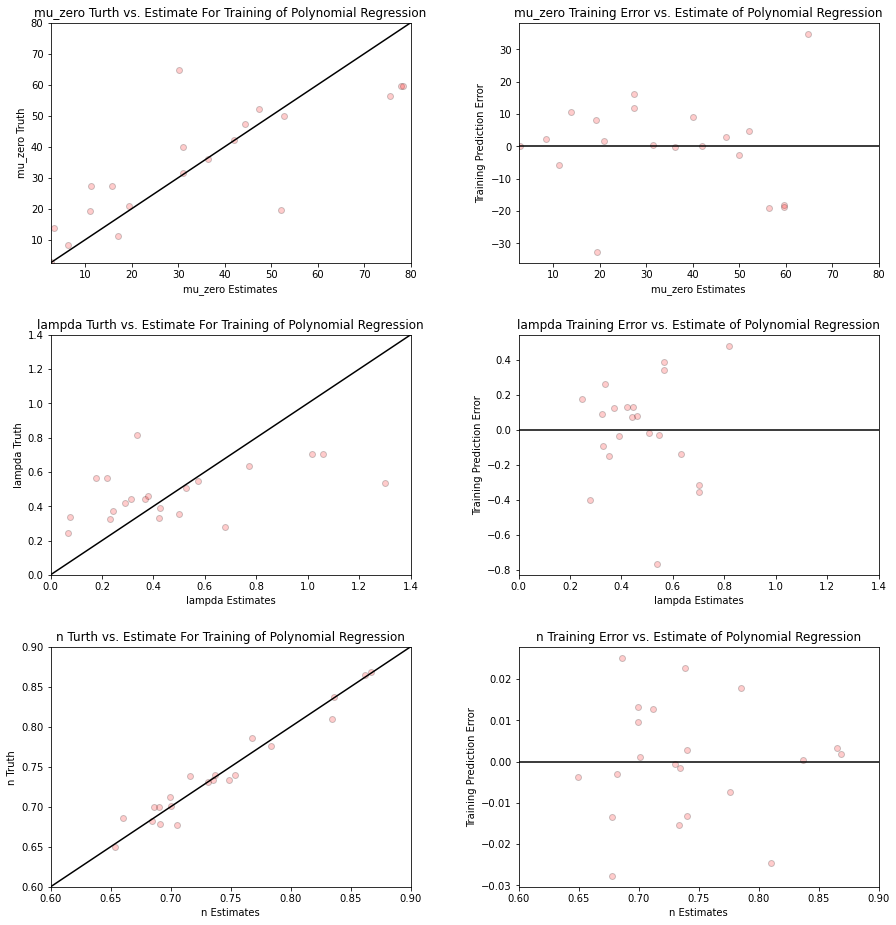

In [18]:
######################################
# Step 1. Make predictions using the training dataset and calculate MSE,Std Deviation,and Variance
######################################
#mu_zero
poly4 = PolynomialFeatures(degree = tuned_order) 
mu_zero_poly4 = poly4.fit_transform(x_train.values) 
lin_poly4 = LinearRegression() 
lin_poly4.fit(mu_zero_poly4, y_train['mu_zero']) 
y_train_pred=lin_poly4.predict(poly4.fit_transform(x_train.values))
y_train_resid = y_train_pred - y_train['mu_zero'].values     # calculate the residuals over the training data
MSE_train = mean_squared_error(y_train['mu_zero'], y_train_pred)           # calculate the training MSE  
print('mu_zero Training: Variance explained  of Polynomial Regression: %.2f' % MSE_train)
print('mu_zero Training: Average error of Polynomial Regression= %.10f' % np.average(y_train_resid)) # calculate the average testing error 
print('mu_zero Training: Standard Deviation error of Polynomial Regression= %.2f' % np.std(y_train_resid)) # calculate the standard deviation testing error

#lampda
poly41 = PolynomialFeatures(degree = tuned_order1) 
lampda_poly41 = poly41.fit_transform(x_train.values) 
lin_poly41 = LinearRegression() 
lin_poly41.fit(lampda_poly41, y_train['lampda']) 
y_train_pred1=lin_poly41.predict(poly41.fit_transform(x_train.values))
y_train_resid1 = y_train_pred1 - y_train['lampda'].values     # calculate the residuals over the testing data
MSE_train1 = mean_squared_error(y_train['lampda'], y_train_pred1)           # calculate the testing MSE  
print('Lampda Training: Variance explained of Polynomial Regression: %.2f' % MSE_train1)
print('Lampda Training: Average error of Polynomial Regression= %.10f' % np.average(y_train_resid1)) # calculate the average testing error 
print('Lampda Training: Standard Deviation error of Polynomial Regression= %.2f' % np.std(y_train_resid1)) # calculate the standard deviation testing error

#n
poly42 = PolynomialFeatures(degree = tuned_order2) 
n_poly42 = poly42.fit_transform(x_train.values) 
lin_poly42 = LinearRegression() 
lin_poly42.fit(n_poly42, y_train['n']) 
y_train_pred2=lin_poly42.predict(poly42.fit_transform(x_train.values))
y_train_resid2 = y_train_pred2 - y_train['n'].values     # calculate the residuals over the testing data
MSE_train2 = mean_squared_error(y_train['n'], y_train_pred2)           # calculate the testing MSE  
print('n Training: Variance explained of Polynomial Regression: %.2f' % MSE_train2)
print('n Training: Average error of Polynomial Regression= %.10f' % np.average(y_train_resid2)) # calculate the average testing error 
print('n Training: Standard Deviation error of Polynomial Regression= %.2f' % np.std(y_train_resid2)) # calculate the standard deviation testing error

######################################
# Step 2. Plot tratining prediction error
######################################
#my zero
plt.subplot(3,3,2)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train['mu_zero'].values,y_train_pred,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Turth vs. Estimate For Training of Polynomial Regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('mu_zero Truth')
plt.plot([mu_min,mu_max],[mu_min,mu_max],c='black')
plt.xlim(mu_min,mu_max); plt.ylim(mu_min,mu_max)

plt.subplot(3,3,3)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred,y_train_resid,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Training Error vs. Estimate of Polynomial Regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('Training Prediction Error')
plt.plot([mu_min,mu_max],[0,0],c='black')
plt.xlim(mu_min,mu_max); #plt.ylim(-100,100)

#lampda
plt.subplot(3,3,5)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train['lampda'].values,y_train_pred1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Turth vs. Estimate For Training of Polynomial Regression'); plt.xlabel('lampda Estimates'); plt.ylabel('lampda Truth')
plt.plot([lampda_min,lampda_max],[lampda_min,lampda_max],c='black')
plt.xlim(lampda_min,lampda_max); plt.ylim(lampda_min,lampda_max)

plt.subplot(3,3,6)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred1,y_train_resid1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Training Error vs. Estimate of Polynomial Regression'); plt.xlabel('lampda Estimates'); plt.ylabel('Training Prediction Error')
plt.plot([lampda_min,lampda_max],[0,0],c='black')
plt.xlim(lampda_min,lampda_max); #plt.ylim(-100,100)

#n
plt.subplot(3,3,8)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_train['n'].values,y_train_pred2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Turth vs. Estimate For Training of Polynomial Regression'); plt.xlabel('n Estimates'); plt.ylabel('n Truth')
plt.plot([n_min,n_max],[n_min,n_max],c='black')
plt.xlim(n_min,n_max); plt.ylim(n_min,n_max)

plt.subplot(3,3,9)                                                # scatter plot of error vs. predictions
plt.scatter(y_train_pred2,y_train_resid2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Training Error vs. Estimate of Polynomial Regression'); plt.xlabel('n Estimates'); plt.ylabel('Training Prediction Error')
plt.plot([n_min,n_max],[0,0],c='black')
plt.xlim(n_min,n_max); #plt.ylim(-100,100)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=3, wspace=0.3, hspace=0.3)
plt.show()

We can observe slightly better prediction with reduction in mu_zero and n variance.Still, even with polynomial models, the prediction seems sparse similar to linear regression.

* Now, Let's check the testing data prediction:

mu_zero Testing: Variance explained of Polynomial Regression: 142.46
mu_zero Testing: Average error of Polynomial Regression= -5.8655810203
mu_zero Testing: Standard Deviation error of Polynomial Regression= 10.39
Lampda Testing: Variance explained of Polynomial Regression: 0.00
Lampda Testing: Average error of Polynomial Regression= -0.0000000000
Lampda Testing: Standard Deviation error of Polynomial Regression= 0.00
n Testing: Variance explained of Polynomial Regression: 0.00
n Testing: Average error of Polynomial Regression= 0.0000000000
n Testing: Standard Deviation error of Polynomial Regression= 0.00


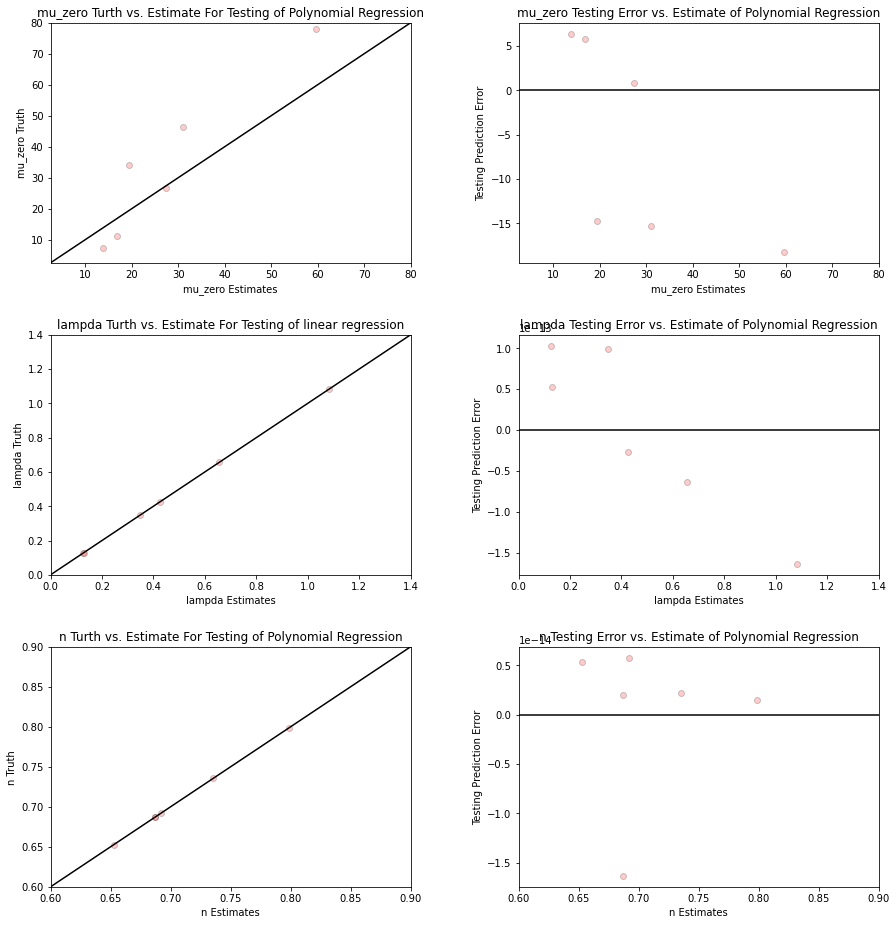

In [19]:
######################################
# Step 1. Make predictions using the testing dataset and calculate MSE,Std Deviation,and Variance
######################################
#mu_zero
poly40 = PolynomialFeatures(degree = tuned_order) 
mu_zero_poly40 = poly40.fit_transform(x_test.values) 
lin_poly40 = LinearRegression() 
lin_poly40.fit(mu_zero_poly40, y_test['mu_zero']) 
y_test_pred=lin_poly4.predict(poly40.fit_transform(x_test.values))
y_test_resid = y_test_pred - y_test['mu_zero'].values     # calculate the residuals over the testing data
MSE_test = mean_squared_error(y_test['mu_zero'], y_test_pred)           # calculate the testing MSE  
print('mu_zero Testing: Variance explained of Polynomial Regression: %.2f' % MSE_test)
print('mu_zero Testing: Average error of Polynomial Regression= %.10f' % np.average(y_test_resid)) # calculate the average testing error 
print('mu_zero Testing: Standard Deviation error of Polynomial Regression= %.2f' % np.std(y_test_resid)) # calculate the standard deviation testing error

#lampda
poly410 = PolynomialFeatures(degree = tuned_order1) 
lampda_poly410 = poly410.fit_transform(x_test.values) 
lin_poly410 = LinearRegression() 
lin_poly410.fit(lampda_poly410, y_test['lampda']) 
y_test_pred1=lin_poly410.predict(poly410.fit_transform(x_test.values))
y_test_resid1 = y_test_pred1 - y_test['lampda'].values     # calculate the residuals over the testing data
MSE_test1 = mean_squared_error(y_test['lampda'], y_test_pred1)           # calculate the testing MSE  
print('Lampda Testing: Variance explained of Polynomial Regression: %.2f' % MSE_test1)
print('Lampda Testing: Average error of Polynomial Regression= %.10f' % np.average(y_test_resid1)) # calculate the average testing error 
print('Lampda Testing: Standard Deviation error of Polynomial Regression= %.2f' % np.std(y_test_resid1)) # calculate the standard deviation testing error

#n
poly420 = PolynomialFeatures(degree = tuned_order2) 
n_poly420 = poly420.fit_transform(x_test.values) 
lin_poly420 = LinearRegression() 
lin_poly420.fit(n_poly420, y_test['n']) 
y_test_pred2=lin_poly420.predict(poly420.fit_transform(x_test.values))
y_test_resid2 = y_test_pred2 - y_test['n'].values     # calculate the residuals over the testing data
MSE_test2 = mean_squared_error(y_test['n'], y_test_pred2)           # calculate the testing MSE  
print('n Testing: Variance explained of Polynomial Regression: %.2f' % MSE_test2)
print('n Testing: Average error of Polynomial Regression= %.10f' % np.average(y_test_resid2)) # calculate the average testing error 
print('n Testing: Standard Deviation error of Polynomial Regression= %.2f' % np.std(y_test_resid2)) # calculate the standard deviation testing error

######################################
# Step 2. Plot testing prediction error
######################################

#my zero
plt.subplot(3,3,2)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test_pred,y_test['mu_zero'].values,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Turth vs. Estimate For Testing of Polynomial Regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('mu_zero Truth')
plt.plot([mu_min,mu_max],[mu_min,mu_max],c='black')
plt.xlim(mu_min,mu_max); plt.ylim(mu_min,mu_max)

plt.subplot(3,3,3)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred,y_test_resid,c='red',alpha=0.2,edgecolor='black')
plt.title('mu_zero Testing Error vs. Estimate of Polynomial Regression'); plt.xlabel('mu_zero Estimates'); plt.ylabel('Testing Prediction Error')
plt.plot([mu_min,mu_max],[0,0],c='black')
plt.xlim(mu_min,mu_max); #plt.ylim(-100,100)

#lampda
plt.subplot(3,3,5)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test_pred1,y_test['lampda'].values,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Turth vs. Estimate For Testing of linear regression'); plt.xlabel('lampda Estimates'); plt.ylabel('lampda Truth')
plt.plot([lampda_min,lampda_max],[lampda_min,lampda_max],c='black')
plt.xlim(lampda_min,lampda_max); plt.ylim(lampda_min,lampda_max)

plt.subplot(3,3,6)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred1,y_test_resid1,c='red',alpha=0.2,edgecolor='black')
plt.title('lampda Testing Error vs. Estimate of Polynomial Regression'); plt.xlabel('lampda Estimates'); plt.ylabel('Testing Prediction Error')
plt.plot([lampda_min,lampda_max],[0,0],c='black')
plt.xlim(lampda_min,lampda_max); #plt.ylim(-100,100)

#n
plt.subplot(3,3,8)                                                # scatter plot of truth values vs. predictions 
plt.scatter(y_test_pred2,y_test['n'].values,c='red',alpha=0.2,edgecolor='black')
plt.title('n Turth vs. Estimate For Testing of Polynomial Regression'); plt.xlabel('n Estimates'); plt.ylabel('n Truth')
plt.plot([n_min,n_max],[n_min,n_max],c='black')
plt.xlim(n_min,n_max); plt.ylim(n_min,n_max)

plt.subplot(3,3,9)                                                # scatter plot of error vs. predictions
plt.scatter(y_test_pred2,y_test_resid2,c='red',alpha=0.2,edgecolor='black')
plt.title('n Testing Error vs. Estimate of Polynomial Regression'); plt.xlabel('n Estimates'); plt.ylabel('Testing Prediction Error')
plt.plot([n_min,n_max],[0,0],c='black')
plt.xlim(n_min,n_max); #plt.ylim(-100,100)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3, top=3, wspace=0.3, hspace=0.3)
plt.show()

As expected, (n) prediction benefited the most from the non-linearity.Meanwhile, mu_zero and lamda were more susceptible to sample data selected and showed sparsity in prediction.

### 5. Results
In this section, I will discuss the findings from linear regression and polynomial models.

* Let us plot relative error of response features (training and testing) to compare linear regression to polynomial (please note the error scale):

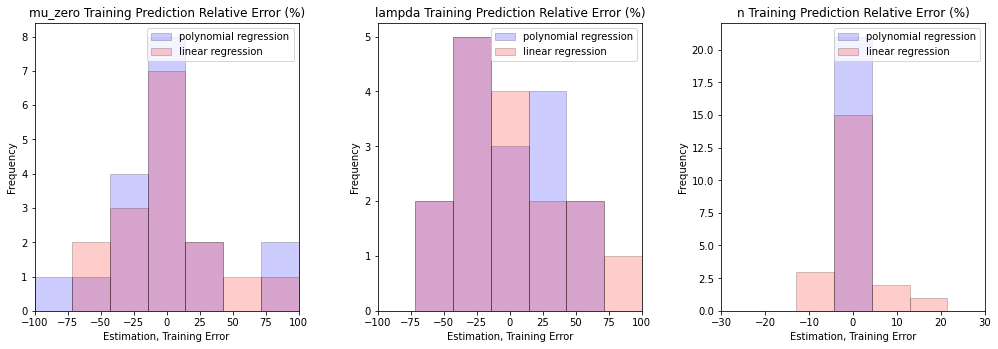

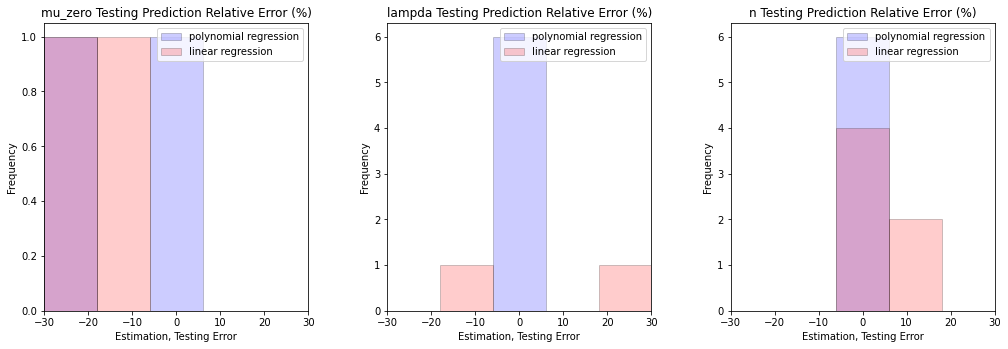

In [20]:
#################################
#Training Relative Error %
#################################
#Histogarm of Errors (Training)
plt.subplot(1,3,1) 
error_min = -100; error_max = 100                   # prediction error range
nbin = 8                                                 # number of bins in histograms
#testing plots
#mu_zero
x=['polynomial regression']
plt.hist(100*y_train_resid/y_train['mu_zero'], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=x)
y=['linear regression']
plt.hist(100*y_train_resid_linear/y_train['mu_zero'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=y)
plt.title('mu_zero Training Prediction Relative Error (%)'); plt.xlabel('Estimation, Training Error'); plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.xlim(error_min,error_max)#; plt.ylim(0,1500000)

#lampda
plt.subplot(1,3,2)
error_min = -100; error_max = 100                   # prediction error range
nbin = 8                                                 # number of bins in histograms
x=['polynomial regression']
plt.hist(y_train_resid1*100/y_train['lampda'], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=x)
y=['linear regression']
plt.hist(y_train_resid1_linear*100/y_train['lampda'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=y)
plt.title('lampda Training Prediction Relative Error (%)'); plt.xlabel('Estimation, Training Error'); plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.xlim(error_min,error_max)#; plt.ylim(0,1500000)

#n
plt.subplot(1,3,3)
error_min = -30; error_max = 30                   # prediction error range
nbin = 8                                                 # number of bins in histograms                                          # number of bins in histograms
x=['polynomial regression']
plt.hist(y_train_resid2*100/y_train['n'], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=x)
y=['linear regression']
plt.hist(y_train_resid2_linear*100/y_train['n'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=y)
plt.title('n Training Prediction Relative Error (%)'); plt.xlabel('Estimation, Training Error'); plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.xlim(error_min,error_max)#; plt.ylim(0,1500000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1, wspace=0.3, hspace=0.2)
plt.show()                                              # histogram of training error

#################################
#Testing Relative Error %
#################################

#Histogarm of Errors (testing)
plt.subplot(1,3,1) 
error_min = -30; error_max = 30                   # prediction error range
nbin = 6                                                 # number of bins in histograms
#testing plots
#mu_zero
x=['polynomial regression']
plt.hist(100*y_test_resid/y_test['mu_zero'], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=x)
y=['linear regression']
plt.hist(100*y_test_resid_linear/y_test['mu_zero'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=y)
plt.title('mu_zero Testing Prediction Relative Error (%)'); plt.xlabel('Estimation, Testing Error'); plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.xlim(error_min,error_max)#; plt.ylim(0,1500000)

#lampda
plt.subplot(1,3,2)
error_min = -30; error_max = 30                  # prediction error range
nbin = 6                                                 # number of bins in histograms
x=['polynomial regression']
plt.hist(y_test_resid1*100/y_test['lampda'], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=x)
y=['linear regression']
plt.hist(y_test_resid1_linear*100/y_test['lampda'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=y)
plt.title('lampda Testing Prediction Relative Error (%)'); plt.xlabel('Estimation, Testing Error'); plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.xlim(error_min,error_max)#; plt.ylim(0,1500000)

#n
plt.subplot(1,3,3)
error_min = -30; error_max = 30                  # prediction error range
nbin = 6                                                 # number of bins in histograms
x=['polynomial regression']
plt.hist(y_test_resid2*100/y_test['n'], alpha = 0.2, color = 'blue', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=x)
y=['linear regression']
plt.hist(y_test_resid2_linear*100/y_test['n'], alpha = 0.2, color = 'red', edgecolor = 'black', bins=np.linspace(error_min,error_max,nbin),label=y)
plt.title('n Testing Prediction Relative Error (%)'); plt.xlabel('Estimation, Testing Error'); plt.ylabel('Frequency')
plt.legend(prop={'size': 10})
plt.xlim(error_min,error_max)#; plt.ylim(0,1500000)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1, wspace=0.3, hspace=0.2)
plt.show()                                              # histogram of training error


**From the histograms and the workflow above, we note the followings:**
* The polynomial model did not improve the prediction significantly for mu_zero and lampda
* The response feature (n) enhanced with the polynomial, which means it has non-linear correlation with predictive features
* The change in polynomial prediction performance when we change the selected training samples means more data are required to have a better prediction
* I recommend investigating if the assumption of independent response features prediction affect response features prediction 


I hope this was helpful,

#### Mohammad Abdullah, Research Assistant, University of Texas at Austin

With five years of industrial experience in chemical EOR domain and field management.Currently, focusing on polymer  and machine learning integration for field-implementation.
___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
